# Praca domowa 3 - Bartosz Rożek

Pracuję na zbiorze projektowym - ceny mieszkań w Kalifornii

In [1]:
setwd("/home/bartosz/Documents/studia/sem6/wb2/")

Wczytanie zbioru i jakiś preprocessing

In [2]:
housing <- read.csv("housing.csv")

housing$total_bedrooms[is.na(housing$total_bedrooms)] = median(housing$total_bedrooms , na.rm = TRUE)

housing$mean_bedrooms = housing$total_bedrooms/housing$households
housing$mean_rooms = housing$total_rooms/housing$households

drops = c('total_bedrooms', 'total_rooms')

housing = housing[ , !(names(housing) %in% drops)]
colnames(housing)

[1] "longitude"          "latitude"           "housing_median_age"
 [4] "population"         "households"         "median_income"     
 [7] "median_house_value" "ocean_proximity"    "mean_bedrooms"     
[10] "mean_rooms"

In [3]:
set.seed(1738) # Set a random seed so that same sample can be reproduced in future runs

sample = sample.int(n = nrow(housing), size = floor(.8*nrow(housing)), replace = F)
train = housing[sample, ] #just the samples
test  = housing[-sample, ] #everything but the samples

In [4]:
train_y = train[,'median_house_value']
train_x = train[, names(train) !='median_house_value']

## Model

Używam modelu z kaggle - random forest

In [5]:
library('randomForest')
rf_model = randomForest(train_x, y = train_y , ntree = 500, importance = TRUE)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



### Predykcja modelu

In [32]:
predict(rf_model, housing[1, -7])
housing[1, 7]

1 
435690.9

[1] 452600

### Explainer 

In [7]:
library(DALEX)
library(DALEXtra)
explainer <- DALEX::explain(model = rf_model,
                     data = housing[, -7],
                     y = housing[, 7])

Welcome to DALEX (version: 2.2.0).
Find examples and detailed introduction at: http://ema.drwhy.ai/


Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



Preparation of a new explainer is initiated
  -> model label       :  randomForest  (  default  )
  -> data              :  20640  rows  9  cols 
  -> target variable   :  20640  values 
  -> predict function  :  yhat.randomForest  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package randomForest , ver. 4.6.14 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  39999.6 , mean =  207130.9 , max =  500001  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -296358.5 , mean =  -275.114 , max =  334253.2  
  A new explainer has been created!  


In [38]:
obs_1 <- housing[1, -7]

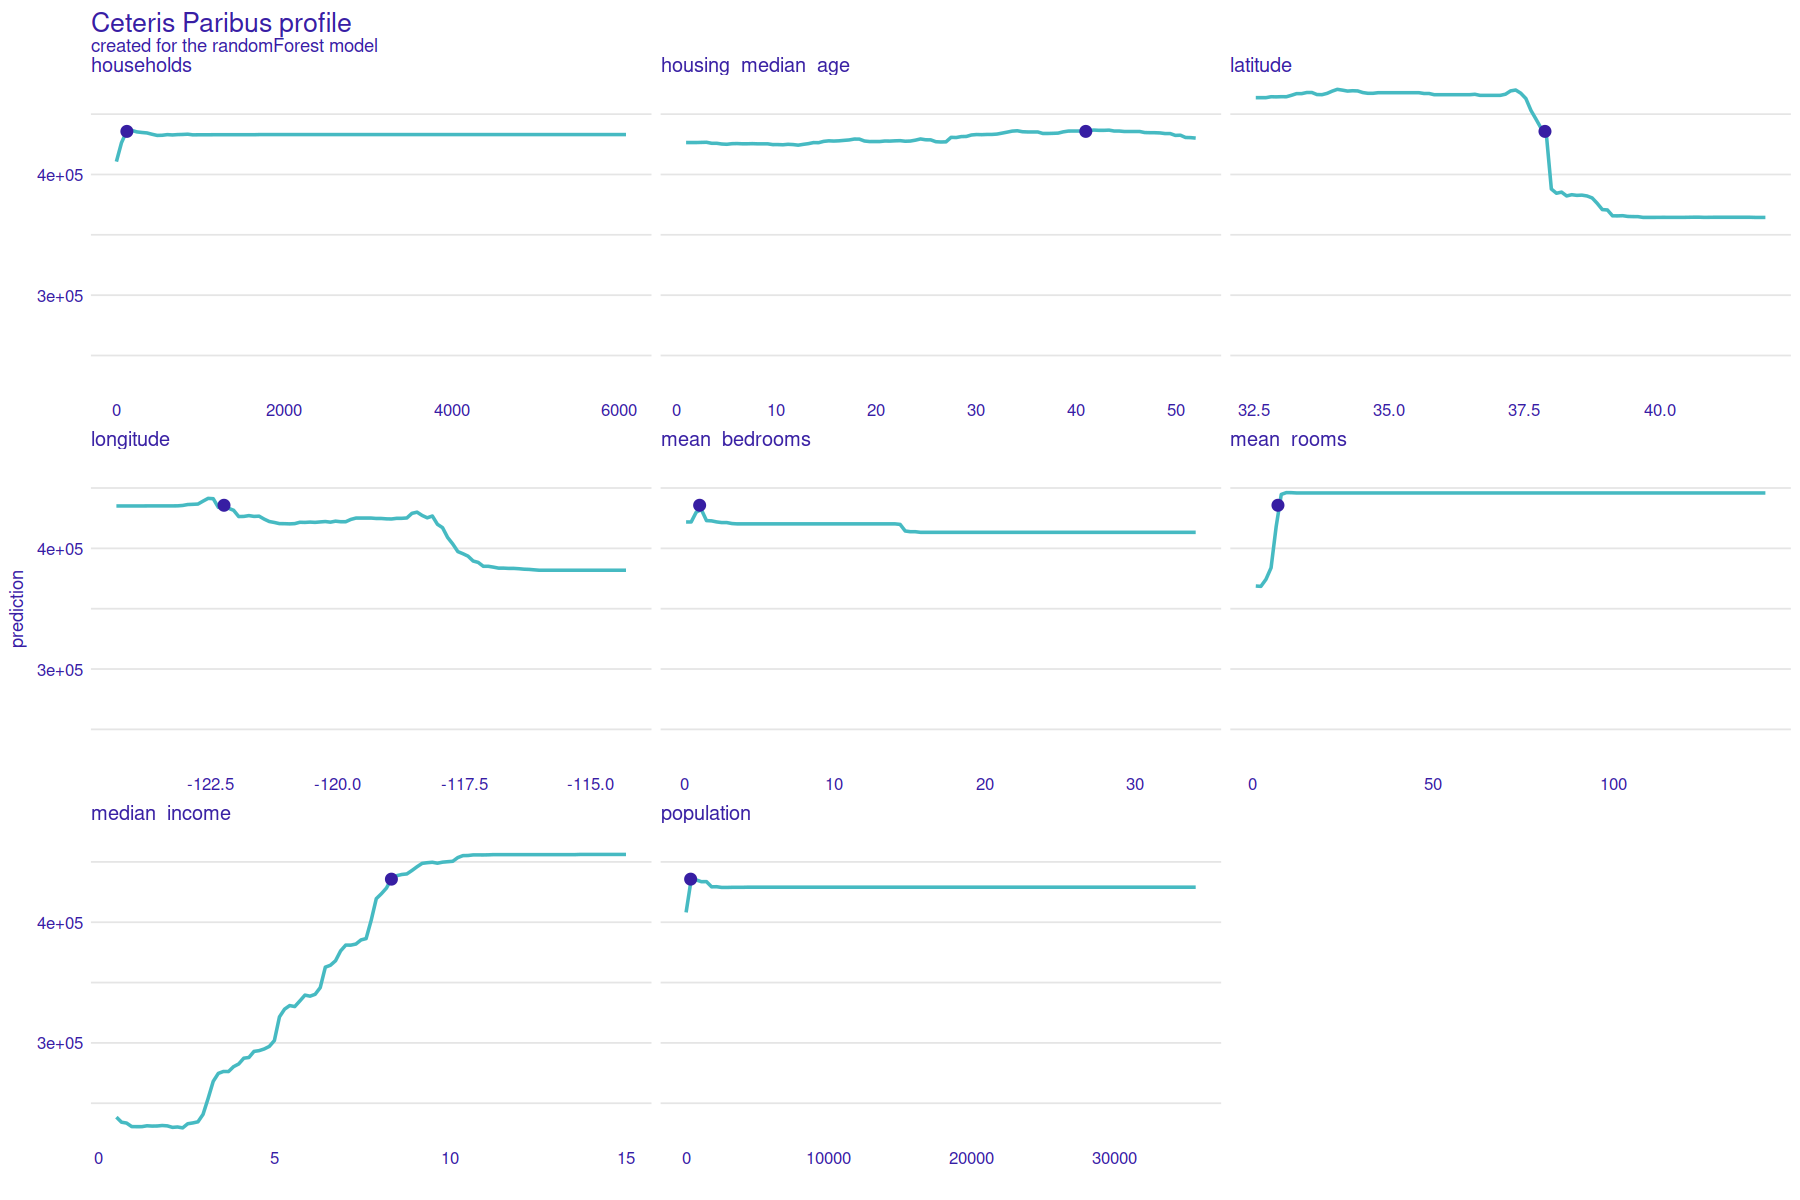

In [39]:
options(repr.plot.width=15, repr.plot.height=10)
cp_rf <- predict_profile(explainer, obs_1)
plot(cp_rf)

- households - zmiana praktycznie nie ma wpływu na wycenę, jedynie dla bardzo bardzo niskich wartości wycena spada, może to wynikać z mniejszej ceny mieszkań "na odludziu"
- housing median age - co ciekawe zmiana tej zmiennej również niezbyt wpływa na cenę, choć mogłoby się wydawać, że nowsze budynki będą tańsze
- latitude - widzimy wyraźny spadek dla wartości większych niż 37.5, czyli mniej więcej poziom San Francisco. Poniżej tej wartości znajdują się popularniejsze miasta, jak np. Los Angeles
- longitude - spadek dla wartości większych od około -117.5. Przez kształt stan Kalifornia są to tereny południowe, okolice San Diego
- mean bedrooms - praktycznie prosta linia
- mean rooms - po przekroczeniu pewnej wartości nie ma wpływu na wycenę
- median income - im wyższy tym wyższa wycena

Główne obserwacje: 
- im wyższe zarobki mieszkańców tym droższe posiadłości - zarobki mieszkańców są skorelowane z przestępczością itp, więc oczywiste, że "dobre" osiedla są droższe
- najdroższe posiadłości są w obszarze pokazanym niżej

![alt text](mapa.png "Title")

In [36]:
obs_2 <- housing[1000, -7]

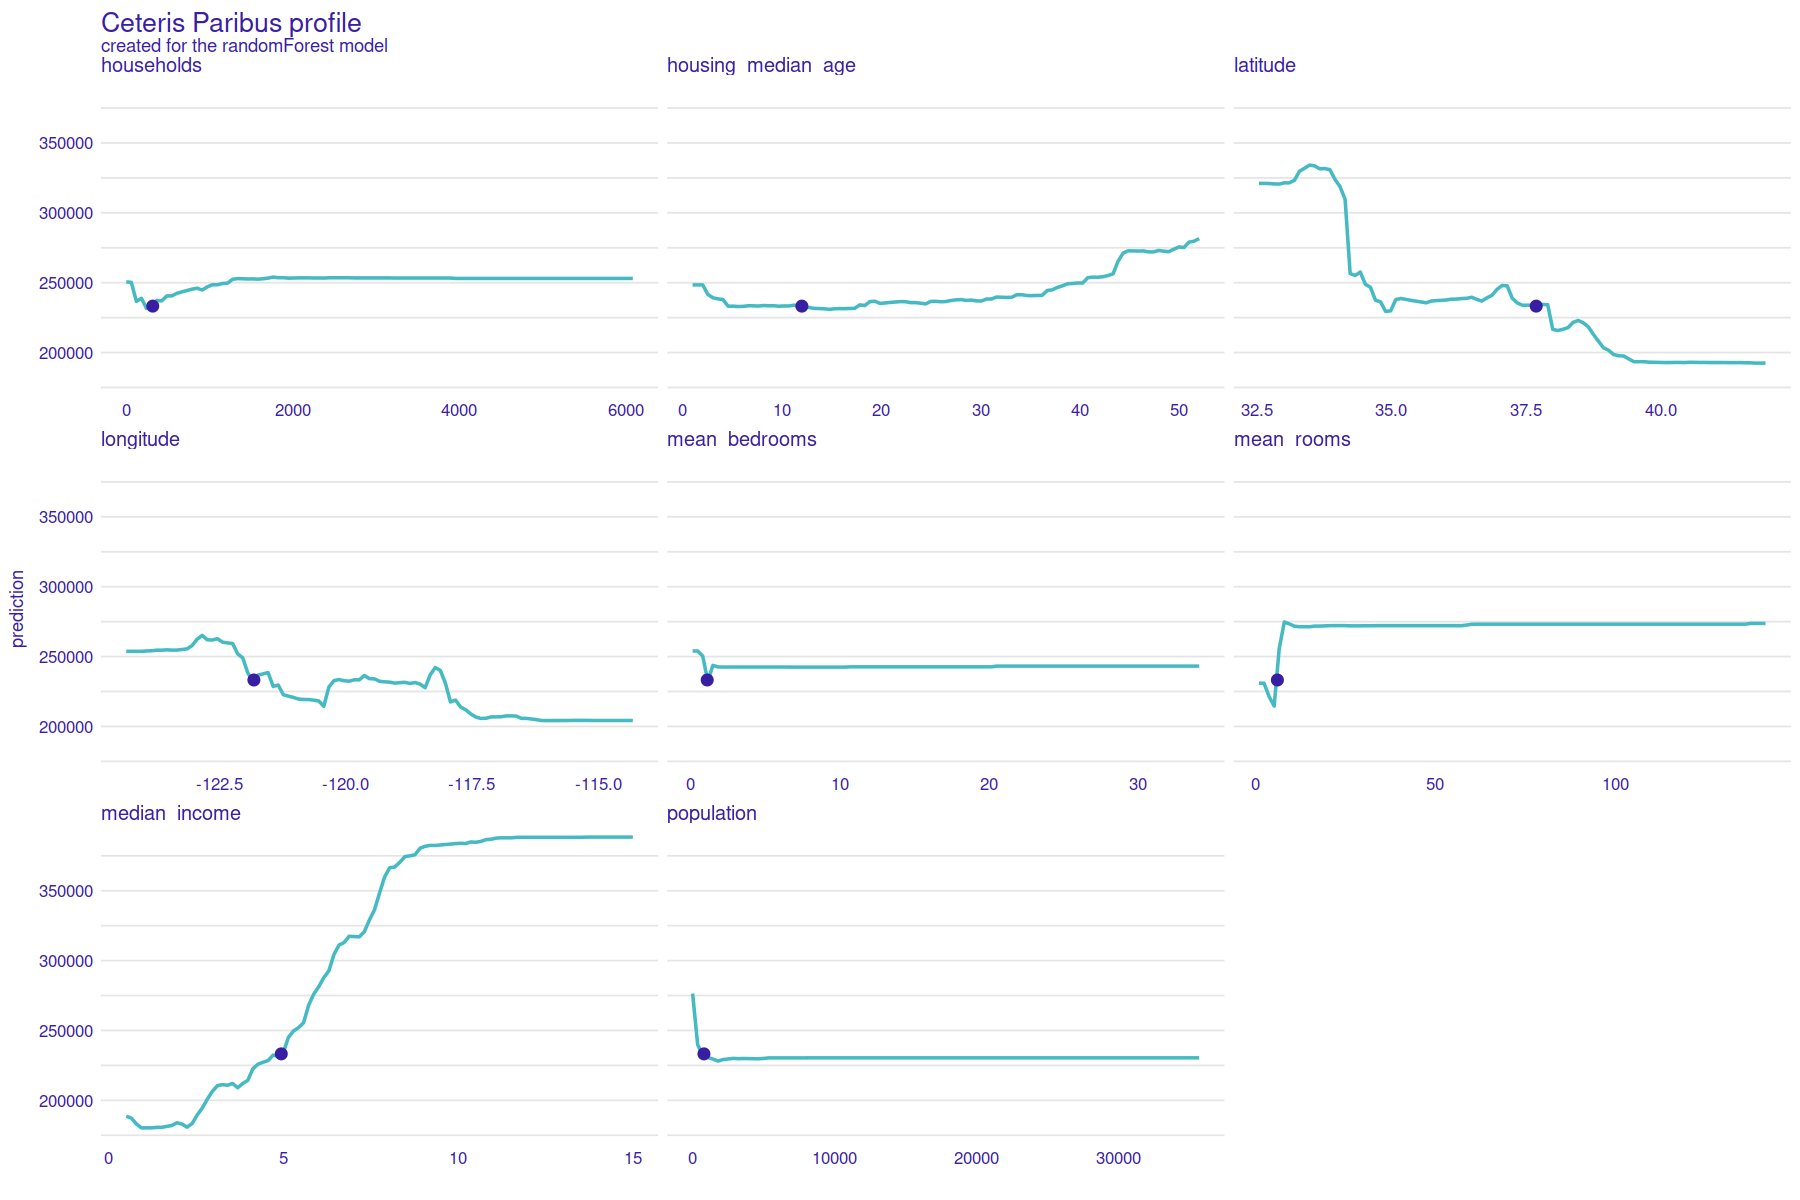

In [41]:
cp_rf2 <- predict_profile(explainer, obs_2)
plot(cp_rf2)

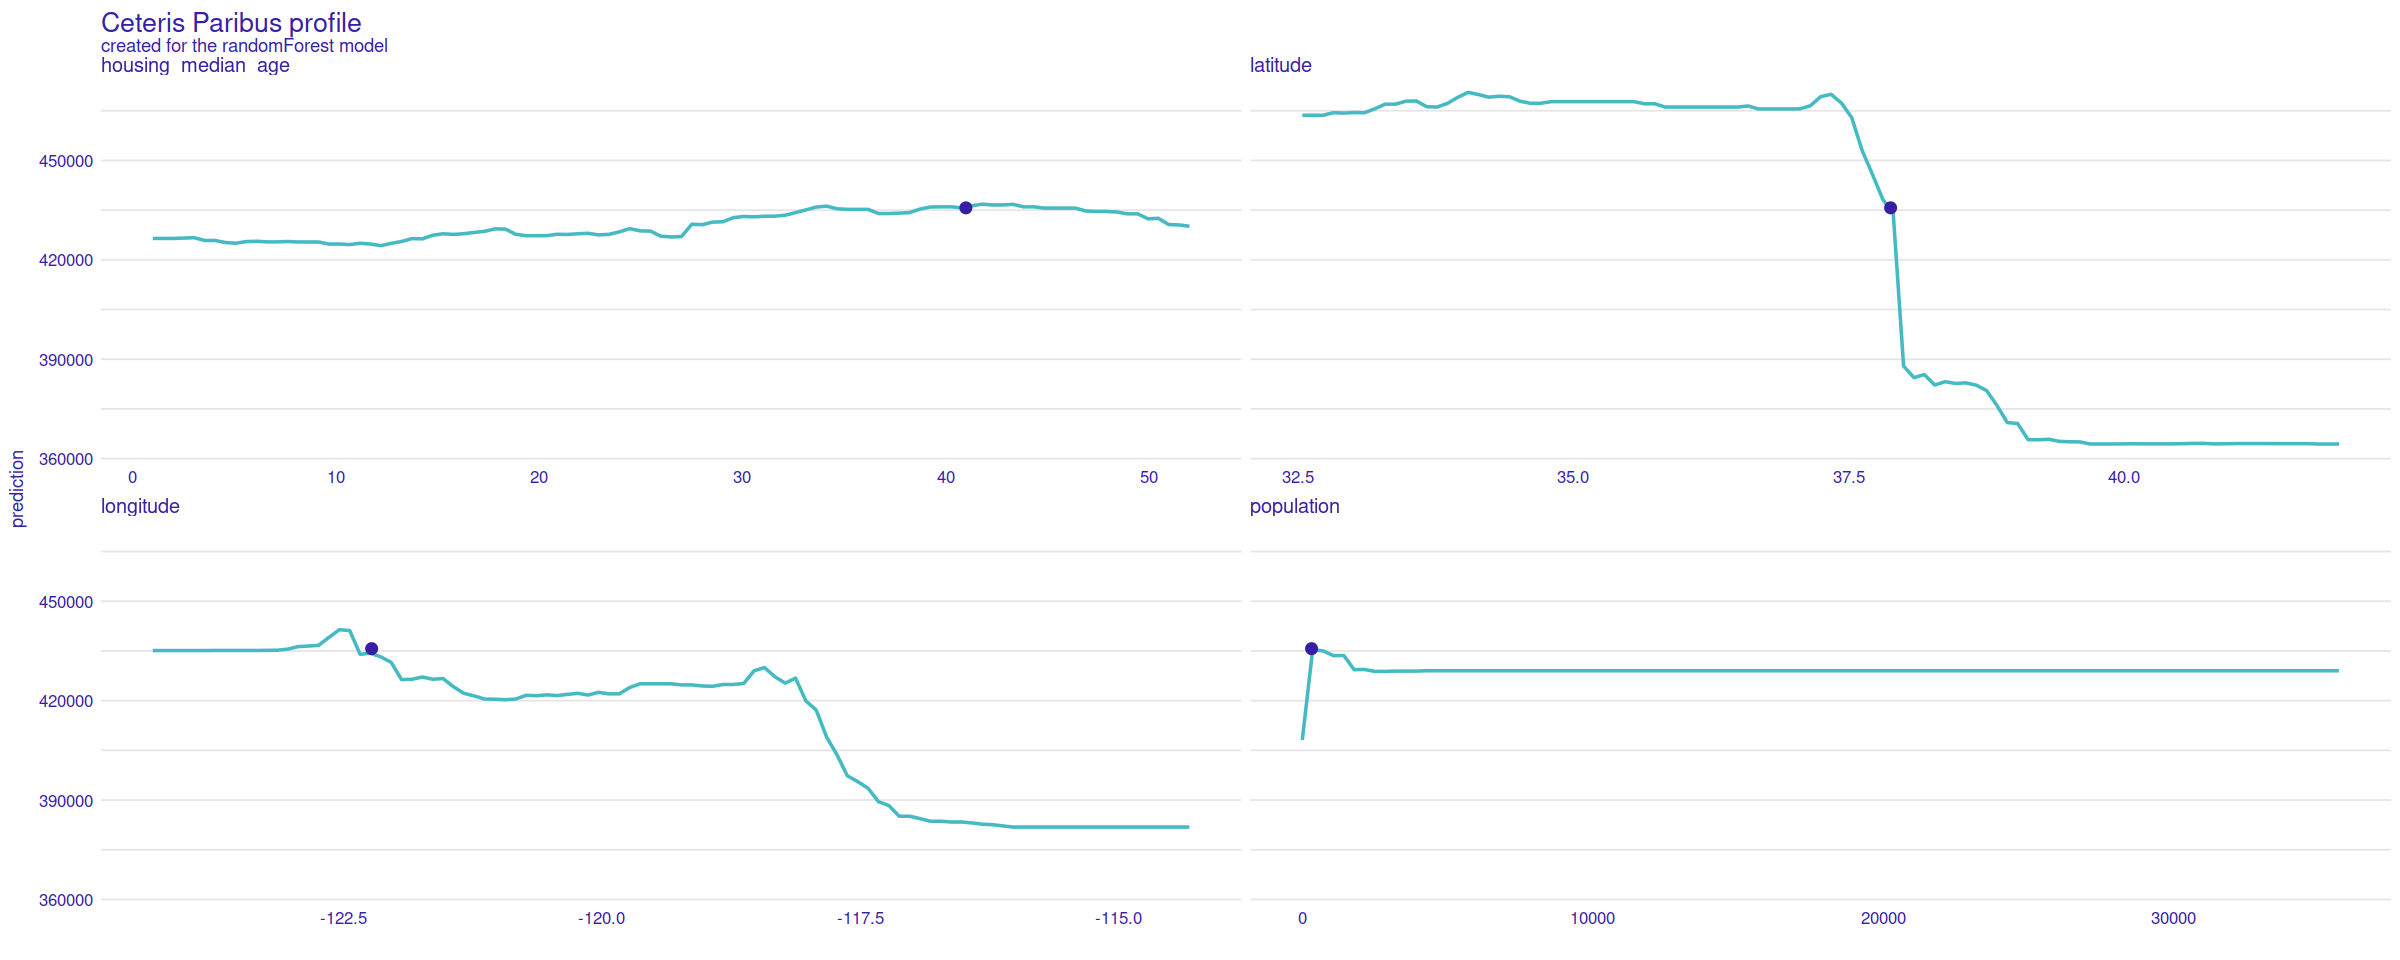

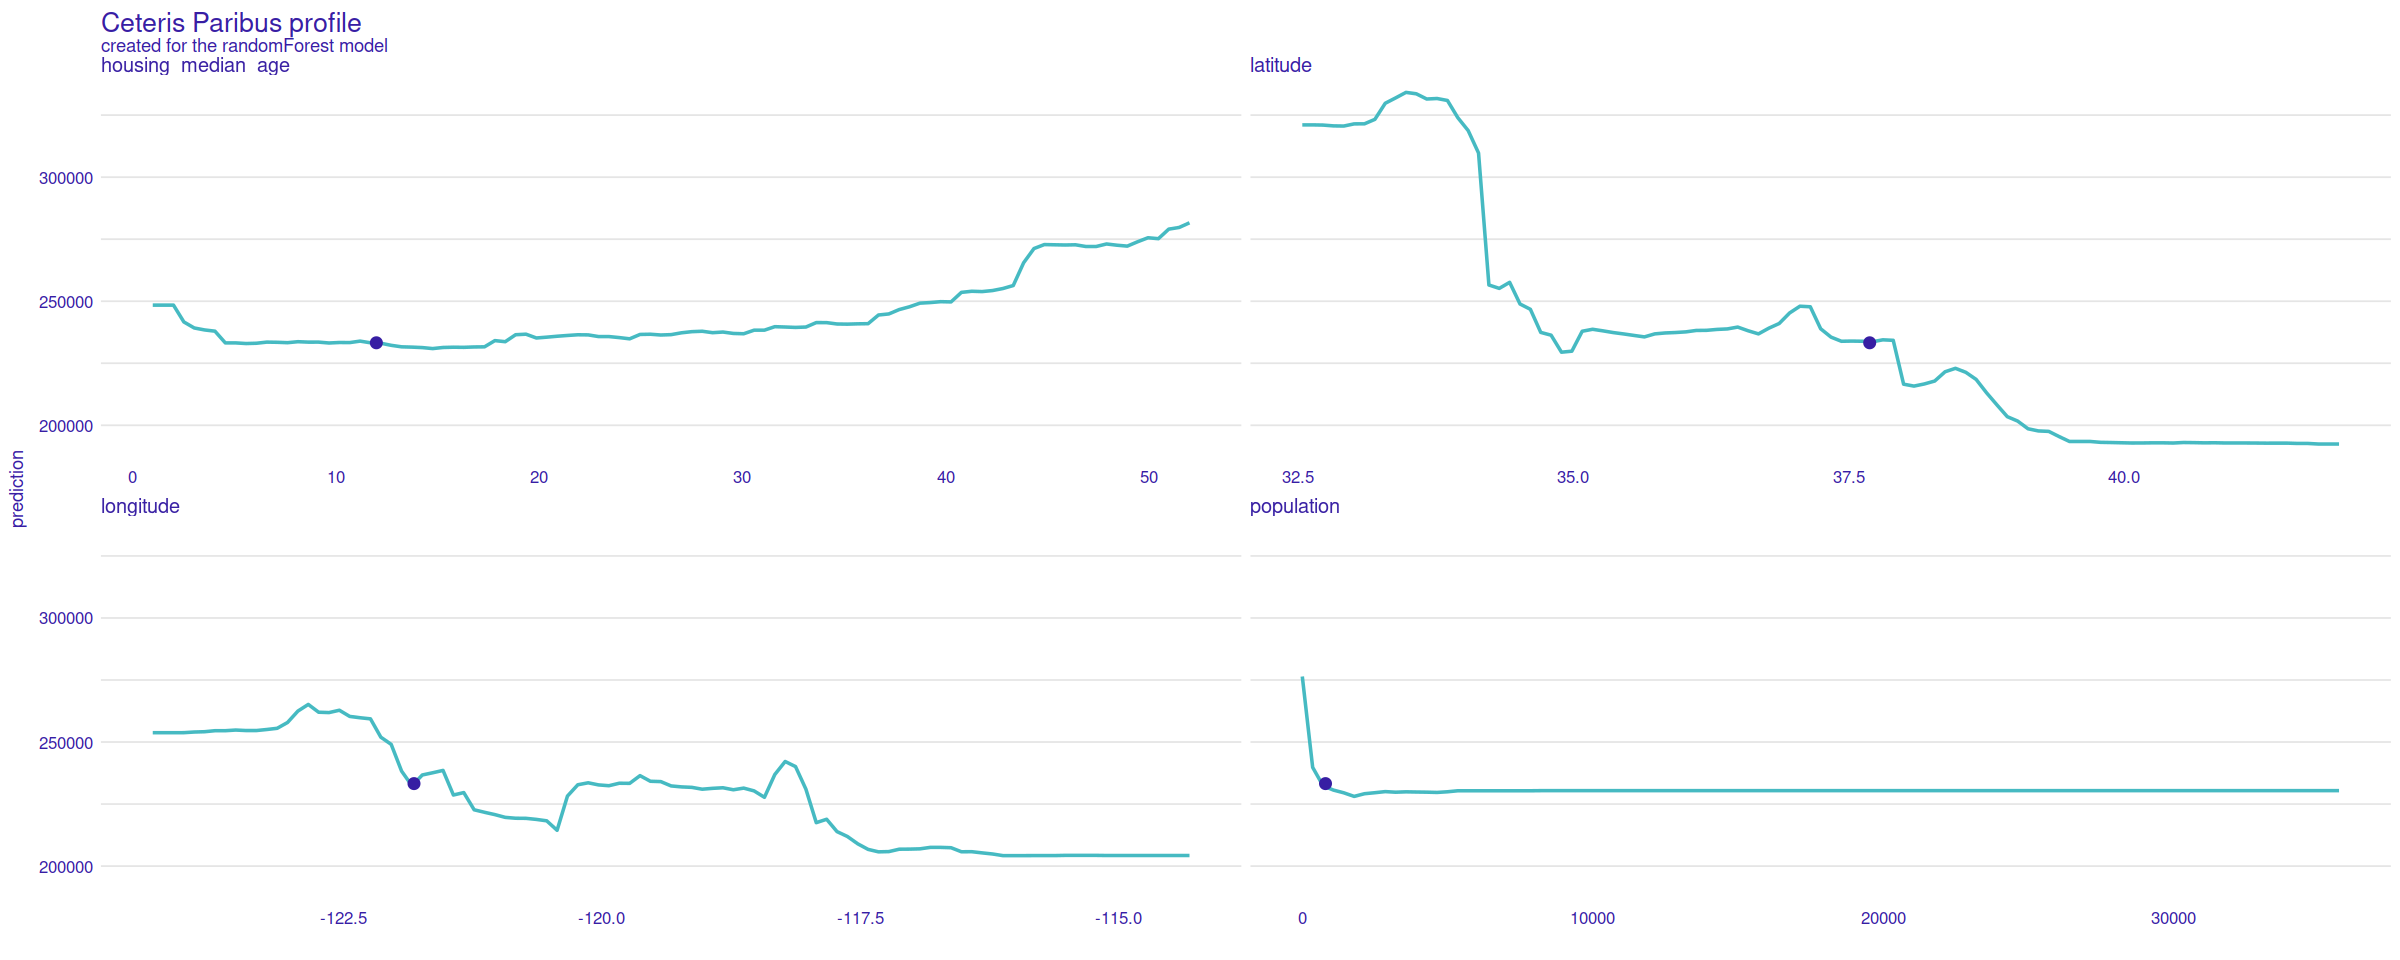

In [57]:
options(repr.plot.width=20, repr.plot.height=8)
plot(cp_rf, variables = c("latitude", "longitude", "population", "housing_median_age"))
plot(cp_rf2, variables = c("latitude", "longitude", "population", "housing_median_age"))

Widzimy, że w przypadku drugiej obserwacji, mamy całkiem inną granicą *latitude* dla droższych mieszkań. *Longitude* zachowuje się inaczej, nie dzieli tak wyraźnie mapy dwie części. *Population* zachowuje się całkiem inaczej, ponieważ w przypadku pierwszej obserwacji zmniejszenie tej zmiennej powoduje spadek predykcji, a w przypadku drugiej wzrost. W przypadku drugiej obserwacji *housing_median_age* wpływa pozytywnie na wycenę przy dużych wartościach tej zmiennej. Możemy przypuszczać, że chodzi o zabytkowe posiadłości.